# Lecture 5 Extension (China A-shares): BYD vs SAIC - Return Ratio Comparison

This notebook applies the Lecture 5 Part 2 return-ratio framework to a China A-share comparison between:
- BYD Co., Ltd. (002594.SZ) - new-energy vehicle (NEV) manufacturer
- SAIC Motor Corporation (600104.SH) - traditional automaker with mixed powertrain exposure

Data are taken from publicly available financial statements (Eastmoney; accessed programmatically for reproducibility). Statement observations are retained from 2022 onward, and trends are visualized over 2024-2025.

## Return ratio set (definitions)

- ROA = Net income / Total assets
- ROE = Net income / Total equity
- Effective tax rate = Income tax / Pretax income
- NOPAT = Operating income * (1 - effective tax rate)
- Capital employed = Total assets - Current liabilities
- ROIC (simplified) = NOPAT / Capital employed
- ROCE = Operating income / Capital employed

## Practical notes

- Balance sheet items are end-of-period stocks; income statement items are period flows.
- For China A-share interim reports, many income statement items are reported on a year-to-date (cumulative) basis. Single-quarter flows are obtained via within-year differences.
- A local copy of the downloaded statements and computed ratios is stored under `data/china_auto/` to support reproducibility and offline use.


In [1]:
# Imports & global settings

from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D


plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

CACHE_DIR = Path('data/china_auto')
CACHE_DIR.mkdir(parents=True, exist_ok=True)

BYD = 'sz002594'   # 002594.SZ
SAIC = 'sh600104'  # 600104.SH

FILTER_START_DATE = '2022-01-01'
PLOT_START = '2024-01-01'
PLOT_END = '2025-12-31'


## Financial reporting conventions and alignment

For China A-share interim reports, income statement line items are typically reported on a year-to-date (cumulative) basis:
- Q1 report: cumulative Q1
- Interim report (H1): cumulative Q1-Q2
- Q3 report: cumulative Q1-Q3
- Annual report: cumulative Q1-Q4 (full year)

To obtain single-quarter flows (e.g., Q3 revenue), use within-year differences between adjacent reporting dates. This allows margins and return metrics to reflect single-quarter performance rather than year-to-date accumulation.

In ratio construction, each quarterly flow is paired with the balance sheet at the same quarter-end date (stocks at period end). For visualization, quarterly observations are linearly interpolated to a monthly grid; interpolation is for chart smoothness only and does not create new financial disclosures.


In [2]:
# Optional: Download / refresh BYD and SAIC statements (run only if needed)
# This cell is intentionally commented out to prevent accidental API calls during class.
#
# import akshare as ak
#
# Profit and balance sheets (Eastmoney via AkShare)
# byd_profit = ak.stock_profit_sheet_by_report_em(symbol=BYD)
# byd_balance = ak.stock_balance_sheet_by_report_em(symbol=BYD)
#
# saic_profit = ak.stock_profit_sheet_by_report_em(symbol=SAIC)
# saic_balance = ak.stock_balance_sheet_by_report_em(symbol=SAIC)
#
# Save to local cache
# byd_profit.to_csv(CACHE_DIR / f"{BYD}_profit_sheet.csv.gz", index=False, compression='gzip')
# byd_balance.to_csv(CACHE_DIR / f"{BYD}_balance_sheet.csv.gz", index=False, compression='gzip')
# saic_profit.to_csv(CACHE_DIR / f"{SAIC}_profit_sheet.csv.gz", index=False, compression='gzip')
# saic_balance.to_csv(CACHE_DIR / f"{SAIC}_balance_sheet.csv.gz", index=False, compression='gzip')


In [3]:
# Load local statement files (no network calls)

byd_profit = pd.read_csv(CACHE_DIR / f"{BYD}_profit_sheet.csv.gz", compression='gzip')
byd_balance = pd.read_csv(CACHE_DIR / f"{BYD}_balance_sheet.csv.gz", compression='gzip')

saic_profit = pd.read_csv(CACHE_DIR / f"{SAIC}_profit_sheet.csv.gz", compression='gzip')
saic_balance = pd.read_csv(CACHE_DIR / f"{SAIC}_balance_sheet.csv.gz", compression='gzip')


In [4]:
def quarterize_cumulative(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    out = df.copy()
    out[cols] = out[cols].apply(pd.to_numeric, errors='coerce')
    q = out[cols].groupby(out.index.year).diff()
    q = q.where(~q.isna(), out[cols])
    return q


def build_quarterly_income(profit_df: pd.DataFrame) -> pd.DataFrame:
    df = profit_df.copy()
    df['REPORT_DATE'] = pd.to_datetime(df['REPORT_DATE'], errors='coerce')
    df = df.dropna(subset=['REPORT_DATE']).sort_values('REPORT_DATE')
    df = df.drop_duplicates('REPORT_DATE', keep='last')
    df = df.set_index('REPORT_DATE')
    df = df[df.index.month.isin([3, 6, 9, 12])]

    net_col = 'PARENTNETPROFIT' if 'PARENTNETPROFIT' in df.columns else 'NETPROFIT'
    need = ['OPERATE_PROFIT', 'TOTAL_PROFIT', 'INCOME_TAX', net_col]
    q = quarterize_cumulative(df, need)

    out = pd.DataFrame(index=df.index)
    out['Operating Income'] = q['OPERATE_PROFIT']
    out['Pretax Income'] = q['TOTAL_PROFIT']
    out['Income Tax'] = q['INCOME_TAX']
    out['Net Income'] = q[net_col]
    return out


def build_balance(balance_df: pd.DataFrame) -> pd.DataFrame:
    df = balance_df.copy()
    df['REPORT_DATE'] = pd.to_datetime(df['REPORT_DATE'], errors='coerce')
    df = df.dropna(subset=['REPORT_DATE']).sort_values('REPORT_DATE')
    df = df.drop_duplicates('REPORT_DATE', keep='last')
    df = df.set_index('REPORT_DATE')
    df = df[df.index.month.isin([3, 6, 9, 12])]

    keep = ['TOTAL_ASSETS', 'TOTAL_EQUITY', 'TOTAL_CURRENT_LIAB']
    out = df[keep].apply(pd.to_numeric, errors='coerce')
    out = out.rename(
        columns={
            'TOTAL_ASSETS': 'Total Assets',
            'TOTAL_EQUITY': 'Total Equity',
            'TOTAL_CURRENT_LIAB': 'Current Liabilities',
        }
    )
    return out


def compute_return_ratios(profit_df: pd.DataFrame, balance_df: pd.DataFrame, start_date: str) -> pd.DataFrame:
    inc = build_quarterly_income(profit_df)
    bs = build_balance(balance_df)

    df = inc.join(bs, how='inner').sort_index()
    df = df[df.index >= pd.Timestamp(start_date)]

    assets = df['Total Assets']
    equity = df['Total Equity']
    current_liab = df['Current Liabilities']

    pretax = df['Pretax Income']
    tax = df['Income Tax']
    tax_rate = (tax / pretax).replace([float('inf'), float('-inf')], pd.NA)
    tax_rate = tax_rate.clip(lower=0, upper=0.35).fillna(0.25)

    op_income = df['Operating Income']
    net_income = df['Net Income']

    capital_employed = assets - current_liab
    nopat = op_income * (1 - tax_rate)

    ratios = pd.DataFrame(
        {
            'ROA': net_income / assets,
            'ROE': net_income / equity,
            'ROIC': nopat / capital_employed,
            'ROCE': op_income / capital_employed,
        },
        index=df.index,
    ).replace([float('inf'), float('-inf')], pd.NA)

    return ratios


def to_monthly(df: pd.DataFrame, start: str, end: str) -> pd.DataFrame:
    out = df.resample('M').interpolate('linear')
    return out.loc[start:end]


In [5]:
byd_ratios_q = compute_return_ratios(byd_profit, byd_balance, start_date=FILTER_START_DATE)
saic_ratios_q = compute_return_ratios(saic_profit, saic_balance, start_date=FILTER_START_DATE)

byd_ratios = to_monthly(byd_ratios_q, start=PLOT_START, end=PLOT_END)
saic_ratios = to_monthly(saic_ratios_q, start=PLOT_START, end=PLOT_END)


C:\Users\Jinquan Ye\AppData\Local\Temp\ipykernel_19784\1098686339.py:85: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  out = df.resample('M').interpolate('linear')
C:\Users\Jinquan Ye\AppData\Local\Temp\ipykernel_19784\1098686339.py:85: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  out = df.resample('M').interpolate('linear')


## Visualization: 2x2 return ratio dashboard

The figure compares the two firms on the same axes for each return metric.

- BYD is shown with a solid line; SAIC is shown with a dashed line.
- Values are displayed as percentages.


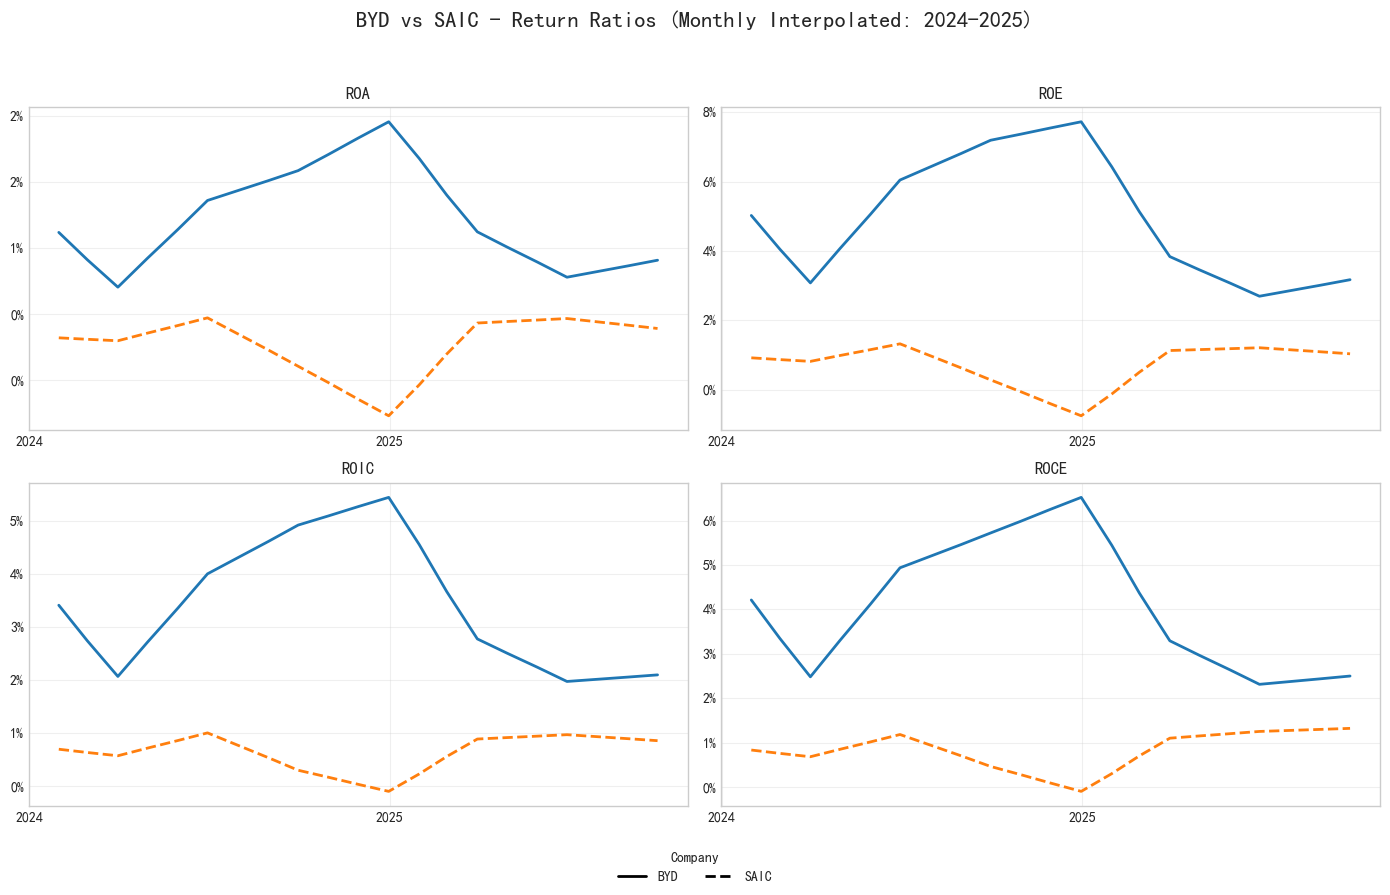

In [6]:
# Visualization: BYD vs SAIC (Solid vs Dashed)

fig, axes = plt.subplots(2, 2, figsize=(14, 9))
fig.suptitle('BYD vs SAIC - Return Ratios (Monthly Interpolated: 2024-2025)', fontsize=16, fontweight='bold')

pairs = [
    ('ROA', axes[0, 0]),
    ('ROE', axes[0, 1]),
    ('ROIC', axes[1, 0]),
    ('ROCE', axes[1, 1]),
]

for metric, ax in pairs:
    ax.plot(byd_ratios.index, byd_ratios[metric], linewidth=2, linestyle='-', label='BYD')
    ax.plot(saic_ratios.index, saic_ratios[metric], linewidth=2, linestyle='--', label='SAIC')

    ax.set_title(metric, fontweight='bold')
    ax.grid(True, alpha=0.3)

    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))

handles = [
    Line2D([0], [0], color='black', linestyle='-', linewidth=2, label='BYD'),
    Line2D([0], [0], color='black', linestyle='--', linewidth=2, label='SAIC'),
]
fig.legend(handles=handles, title='Company', loc='lower center', ncol=2, frameon=False, fontsize=10)

plt.tight_layout(rect=[0, 0.06, 1, 0.95])
plt.show()


## Discussion prompts

1. **ROA vs ROE**: When can ROE rise while ROA remains flat? Relate the difference to leverage and equity base dynamics.
2. **ROIC vs ROCE**: Compare the role of taxes and operating profitability. Why does ROIC (after-tax) typically lie below ROCE (pre-tax)?
3. **Cross-firm comparison**: How do business model and capital intensity differences between a NEV-focused manufacturer and a traditional automaker map into return ratios?
4. **Caveats**: Consider seasonality, interim reporting conventions, and potential statement restatements when interpreting short-horizon movements.
